In [1]:
# The Laplace Bridge
# https://arxiv.org/pdf/2003.01227

In [3]:
import torch
import sys
sys.path.append('../src')
from relaxit.distributions.LogisticNormalSoftmax import LogisticNormalSoftmax
from relaxit.distributions.approx import lognorm_approximation_fn, dirichlet_approximation_fn
from pyro.distributions import Dirichlet

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import torch

# Define the corners of the triangle
CORNERS = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])

# Create the initial triangulation
TRIANGLE = tri.Triangulation(CORNERS[:, 0], CORNERS[:, 1])

# Compute midpoints of the triangle sides
MIDPOINTS = [(CORNERS[(i + 1) % 3] + CORNERS[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    """Converts 2D Cartesian coordinates to barycentric."""
    s = [(CORNERS[i] - MIDPOINTS[i]).dot(xy - MIDPOINTS[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def argmin_norm(sample, positions):
    """Finds the index of the closest point in positions to sample."""
    return np.argmin(np.sum(np.square(sample - positions), axis=1))

def refine_triangulation(subdiv=5):
    """Refines the triangulation and returns the refined mesh."""
    refiner = tri.UniformTriRefiner(TRIANGLE)
    return refiner.refine_triangulation(subdiv=subdiv)

def plot_contours(trimesh, pvals, nlevels=200, **kwargs):
    """Plots the contours of the probability values on the triangulated mesh."""
    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()

def sample_and_plot(distribution, nlevels=200, subdiv=5, num_samples=100000, **kwargs):
    """Samples from a given distribution and plots the contours."""
    trimesh = refine_triangulation(subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    samples = distribution.sample((num_samples,))
    counts = np.zeros(len(xys))
    for x in samples:
        counts[argmin_norm(x.numpy(), xys)] += 1

    pvals = counts / num_samples
    plot_contours(trimesh, pvals, nlevels, **kwargs)

Here we visualize the approximation in both sides:
- Dirichlet to LogisticNormal
- LogisticNormal to Dirichlet

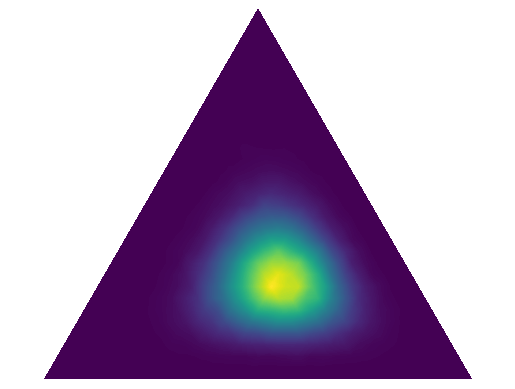

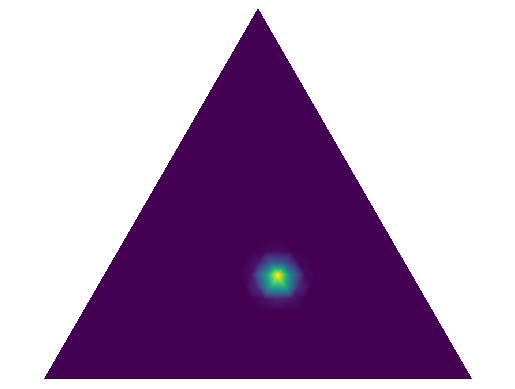

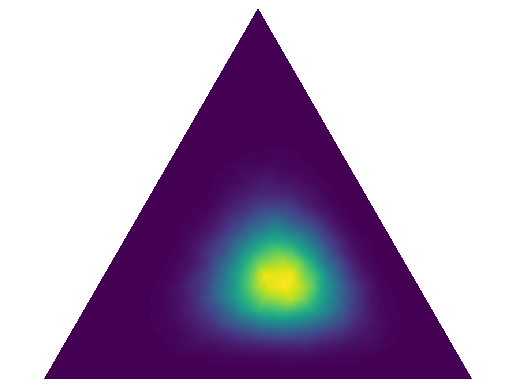

In [6]:
# Generate a random concentration parameter
concentration = torch.randint(1, 10, (3,), dtype=torch.float)

# Create the Dirichlet distribution
dirichlet_distribution = Dirichlet(concentration)

# Approximate the Dirichlet distribution with a LogisticNormal distribution
lognorm_approximation = lognorm_approximation_fn(dirichlet_distribution)
loc = lognorm_approximation.loc
scale = lognorm_approximation.scale

# Approximate the LogisticNormal distribution with a Dirichlet distribution
dirichlet_approximation = dirichlet_approximation_fn(lognorm_approximation)
concentration_approx = dirichlet_approximation.concentration

# Assert that the original and approximated concentration parameters are close
assert torch.allclose(concentration, concentration_approx)

# Sample and plot from the distributions
sample_and_plot(dirichlet_distribution)
sample_and_plot(lognorm_approximation)
sample_and_plot(dirichlet_approximation)